In [1]:
import numpy as np
import pandas as pd
from scipy import stats
#import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_yearly, plot_forecast_component
from time import strptime
from funcs import *

This notebook deals with monthly revenue data for seven different brands.  
After import/clean we have the following data frame  
**df**   
index: datetime  
columns: Casual DateLine, Fonochat, GuySpy Voice, InteractiveMale, LiveLinks, TangoPersonals, Vibeline, totalrev, gay

1. [Import/clean data](#import)
2. [Initial forecasts](#initialforecasts)

<a name='import'></a>
# Import/clean data

Import the data (may need to install the necessary excel addon for read_excel):

In [2]:
df = pd.read_excel('revenue.xls')

In [3]:
df.head()

,Net Revenue USD for FY18 Revenue Budget (Fiscal Month),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
1,NaN,Net Revenue USD,Net Revenue USD,Net Revenue USD,Net Revenue USD,Net Revenue USD,Net Revenue USD,Net Revenue USD
2,FY2010-Jan,377939,320808,NaN,880817,1.80757e+06,259958,258467
3,FY2010-Feb,337159,335724,NaN,837174,1.76726e+06,256983,275816
4,FY2010-Mar,387546,384028,NaN,915134,1.89768e+06,282160,279183


Ok, drop rows 0 and 2, and replace NaN's with zeroes:

In [4]:
df = pd.read_excel('revenue.xls', skiprows=[0,2])
df.fillna(0, inplace=True)

In [5]:
df.tail()

,Unnamed: 0,Casual DateLine,Fonochat,GuySpy Voice,InteractiveMale,LiveLinks,TangoPersonals,Vibeline
103,FY2018-Aug,86893.175322,137636.0391,160546.3467,77545.124952,699939.017528,61203.852129,92391.97591
104,FY2018-Sep,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000
105,FY2018-Oct,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000
106,FY2018-Nov,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000
107,FY2018-Dec,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000


Drop empty rows as well as last actual month since it was incomplete:

In [6]:
df.drop(range(103,108),inplace=True)

Rename the date column using df.rename(columns=dict, inplace=True)
Note: this syntax for merging dicts x, y is new to python 3.5:  z = {**x, **y} 

In [7]:
df.rename(columns={**{'Unnamed: 0': 'Date'}, **{df.columns[k]: df.columns[k] for k in range(1, len(df.columns)) }}, inplace=True)

Format the date column as YYYY-MM string, then convert to datetime:

In [8]:
df['Date'] = df['Date'].apply(lambda x: x[2:7] + str(strptime(x[-3::],"%b").tm_mon).zfill(2))

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

Set date as the index:

In [10]:
df.set_index('Date', inplace=True)

A quick plot of the data:

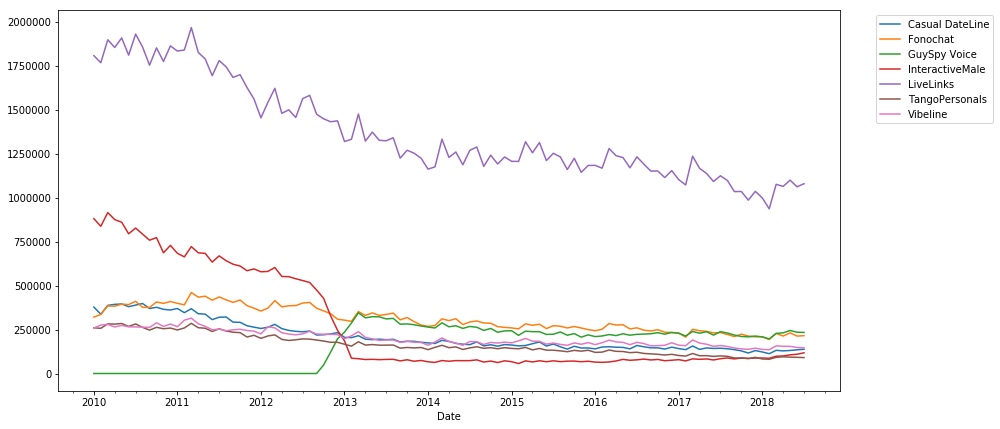

In [11]:
df.plot(legend=False, figsize=(14,7))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Let's add a column for Total Revenue:

In [12]:
df['totalrev'] = df.sum(axis='columns')

Add a column for gay combined (GSV+IM):

In [13]:
df['gay'] = df['GuySpy Voice'] + df['InteractiveMale']

In [14]:
df.columns

Index(['Casual DateLine', 'Fonochat', 'GuySpy Voice', 'InteractiveMale',
       'LiveLinks', 'TangoPersonals', 'Vibeline', 'totalrev', 'gay'],
      dtype='object')

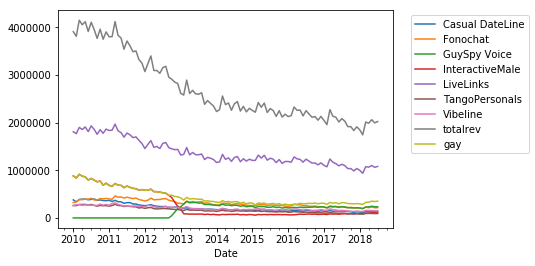

In [15]:
df.plot(legend=False)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

<a initialforecasts></a>
# Initial forecasts

We start by forecasting for separate brands as well as totalrev, using our chosen default values
(mode='multiplicative', periods=18, freq='M',fourier=10, season_prior=10.0)

In [16]:
series = {}
forecasts = {}
names = []
for brand in df.columns.drop(['GuySpy Voice', 'InteractiveMale']):
    series[brand], forecasts[brand] = fitandforecast(df, brand, interval_width=0.9)
    names.append(brand)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\JamieG\AppData\Local\conda\conda\envs\ds\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

In [17]:
forecasts['Fonochat'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 16 columns):
ds                            121 non-null datetime64[ns]
trend                         121 non-null float64
yhat_lower                    121 non-null float64
yhat_upper                    121 non-null float64
trend_lower                   121 non-null float64
trend_upper                   121 non-null float64
multiplicative_terms          121 non-null float64
multiplicative_terms_lower    121 non-null float64
multiplicative_terms_upper    121 non-null float64
yearly                        121 non-null float64
yearly_lower                  121 non-null float64
yearly_upper                  121 non-null float64
additive_terms                121 non-null float64
additive_terms_lower          121 non-null float64
additive_terms_upper          121 non-null float64
yhat                          121 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 15.2 KB


In [20]:
selectcols = ['ds', 'yhat', 'yhat_upper', 'yhat_lower']
renamecols = ['date', 'rev_forecast', 'upper_estimate', 'lower_estimate'] 

output_total = forecasts['totalrev'][selectcols].rename(columns=dict(zip(selectcols, renamecols)))
output_total.to_csv('output/total_revenue_forecast.csv', index=False)

output_by_brand = pd.concat([forecasts[brand]['yhat'].rename(brand) for brand in names], axis=1).set_index(
    forecasts[names[0]]['ds'].values)
output_by_brand.to_csv('output/revenue_forecasts_by_brand.csv')

In [21]:
output_total.head(n=2)

,date,rev_forecast,upper_estimate,lower_estimate
0,2010-01-01,3.899741e+06,3.982831e+06,3.808366e+06
1,2010-02-01,3.862793e+06,3.951074e+06,3.774291e+06


In [22]:
output_by_brand.head(n=2)

,Casual DateLine,Fonochat,LiveLinks,TangoPersonals,Vibeline,totalrev,gay
2010-01-01,389592.658677,336887.172850,1.808110e+06,265878.850338,263300.325348,3.899741e+06,872254.798999
2010-02-01,367421.349710,337803.655196,1.803593e+06,267986.089279,284563.675663,3.862793e+06,822392.655836


In [18]:
combined_forecast = forecasts[names[0]].iloc[:,1:]
# combined_series = series[names[0]].iloc[:,1:]
for brand in names[1:]:
    if brand != 'totalrev':
        combined_forecast += forecasts[brand].iloc[:,1:]
#     combined_series += series[brand].iloc[:,1:]
    
combined_forecast['ds'] = forecasts[names[0]]['ds']
combined_forecast.set_index(forecasts[names[0]]['ds'], inplace=True)
# combined_series['ds'] = combined_series[names[0]]['ds']

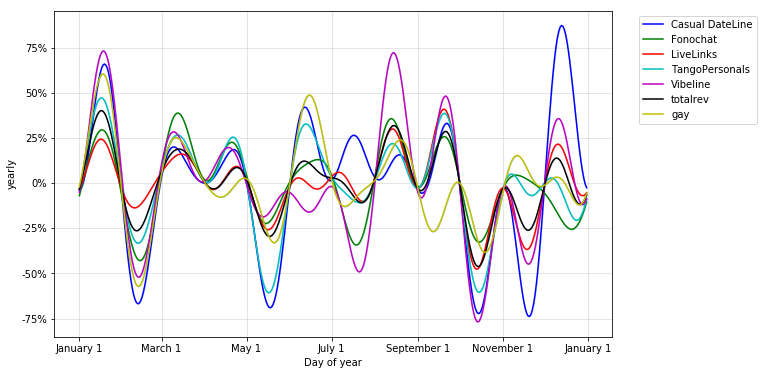

In [19]:
seasoncompare(list(series.values()), names=names)

(1000000, 3000000)

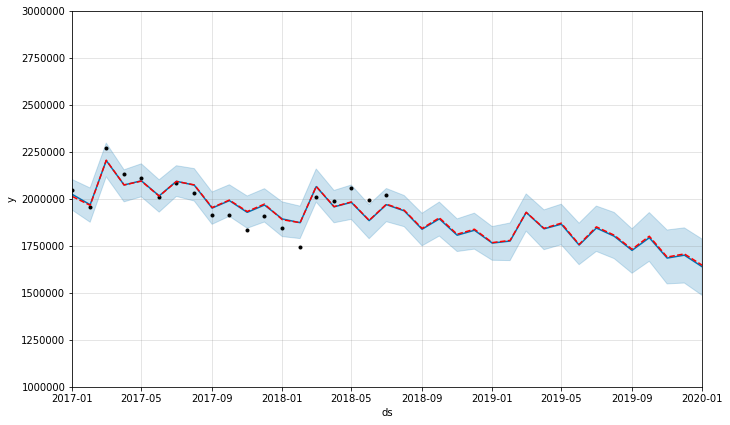

In [20]:
fig1 = series['totalrev'].plot(forecasts['totalrev'])
ax1 = plt.gca()
plt.plot(combined_forecast['yhat'], 'r--')
ax1.set_xlim(pd.Timestamp('2017'), pd.Timestamp('2020'))
ax1.set_ylim([1000000,3000000])

## Warmup

We'll warm up with a forecast of the LiveLinks brand.

Instantiate a new Prophet object:

In [13]:
# def df_for_forecast(df, column):
#     """Given dataframe df indexed by datetime, 
#     gives correctly formatted input for Prophet.fit(), 
#     namely a dataframe with two columns:
#     'ds'=date and 'y'=seriesdata 
#     Here seriesdata is contained in the column of df
#     called 'column' (string)  """
#     return pd.DataFrame({'ds': df.index, 'y': df[column]}, columns=['ds', 'y'])

In [14]:
LiveLinks_ts = Prophet(seasonality_mode='multiplicative')
LiveLinks_ts.fit(df_for_forecast(df, 'LiveLinks'))

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [73]:
LiveLinks_future = LiveLinks_ts.make_future_dataframe(periods=12, freq='MS')
LiveLinks_future.tail()

NameError: name 'LiveLinks_ts' is not defined

In [16]:
LiveLinks_forecast=LiveLinks_ts.predict(LiveLinks_future)

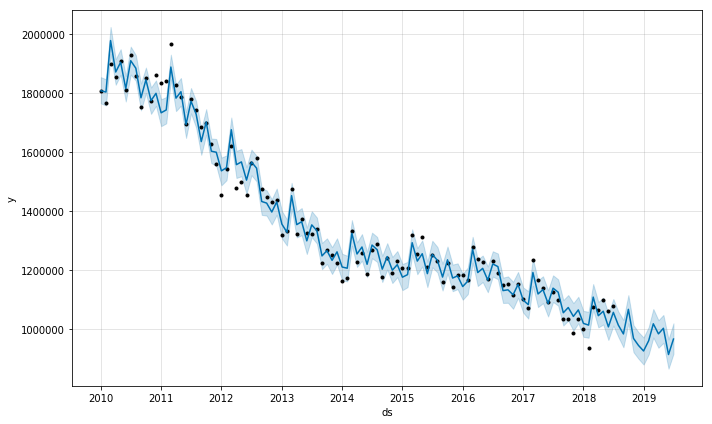

In [17]:
fig = LiveLinks_ts.plot(LiveLinks_forecast)

In [16]:
ll, llforecast = fitandforecast(df, 'LiveLinks',interval_width=0.9)
#(df, brand, interval_width=0.9)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [17]:
llforecast.tail(n=24)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
97,2018-02-01,1.053415e+06,9.575605e+05,1.071898e+06,1.053415e+06,1.053415e+06,-0.037753,-0.037753,-0.037753,-0.037753,-0.037753,-0.037753,0.0,0.0,0.0,1.013646e+06
98,2018-03-01,1.047534e+06,1.053410e+06,1.165211e+06,1.047534e+06,1.047534e+06,0.058245,0.058245,0.058245,0.058245,0.058245,0.058245,0.0,0.0,0.0,1.108548e+06
99,2018-04-01,1.041024e+06,9.855592e+05,1.101568e+06,1.041024e+06,1.041024e+06,0.004314,0.004314,0.004314,0.004314,0.004314,0.004314,0.0,0.0,0.0,1.045514e+06
100,2018-05-01,1.034723e+06,1.006545e+06,1.118093e+06,1.034723e+06,1.034723e+06,0.025082,0.025082,0.025082,0.025082,0.025082,0.025082,0.0,0.0,0.0,1.060676e+06
101,2018-06-01,1.028213e+06,9.508473e+05,1.066163e+06,1.028213e+06,1.028213e+06,-0.020059,-0.020059,-0.020059,-0.020059,-0.020059,-0.020059,0.0,0.0,0.0,1.007587e+06
102,2018-07-01,1.021912e+06,9.973328e+05,1.113519e+06,1.021912e+06,1.021912e+06,0.034269,0.034269,0.034269,0.034269,0.034269,0.034269,0.0,0.0,0.0,1.056931e+06
103,2018-08-01,1.015401e+06,9.861699e+05,1.095586e+06,1.015052e+06,1.016019e+06,0.023561,0.023561,0.023561,0.023561,0.023561,0.023561,0.0,0.0,0.0,1.039325e+06
104,2018-09-01,1.008891e+06,9.223820e+05,1.034468e+06,1.007400e+06,1.010985e+06,-0.027832,-0.027832,-0.027832,-0.027832,-0.027832,-0.027832,0.0,0.0,0.0,9.808114e+05
105,2018-10-01,1.002590e+06,9.534228e+05,1.071046e+06,9.990726e+05,1.006860e+06,0.008484,0.008484,0.008484,0.008484,0.008484,0.008484,0.0,0.0,0.0,1.011096e+06
106,2018-11-01,9.960796e+05,9.135829e+05,1.026397e+06,9.896517e+05,1.002717e+06,-0.027004,-0.027004,-0.027004,-0.027004,-0.027004,-0.027004,0.0,0.0,0.0,9.691814e+05


In [19]:
llforecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

(0, 1850000)

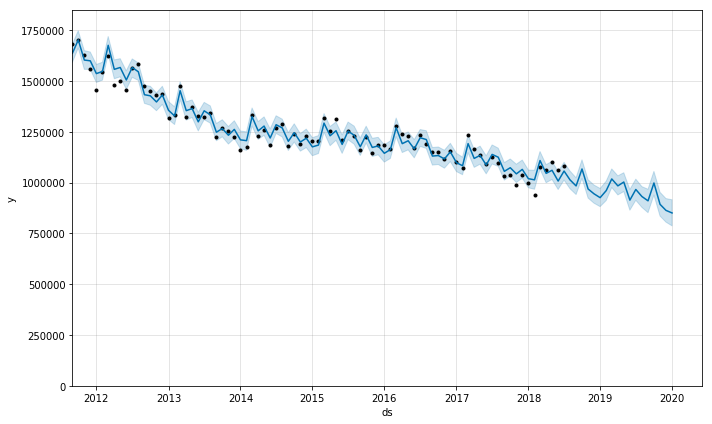

In [20]:
fig2 = ll.plot(llforecast)
fig2ax=plt.gca()
fig2ax.set_xlim(pd.Timestamp('2011-09'), pd.Timestamp('2020-06'))
fig2ax.set_ylim(top=1850000, bottom=0)

In [21]:
gross, gross_forecast = fitandforecast(df, 'totalrev')

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0, 4000000)

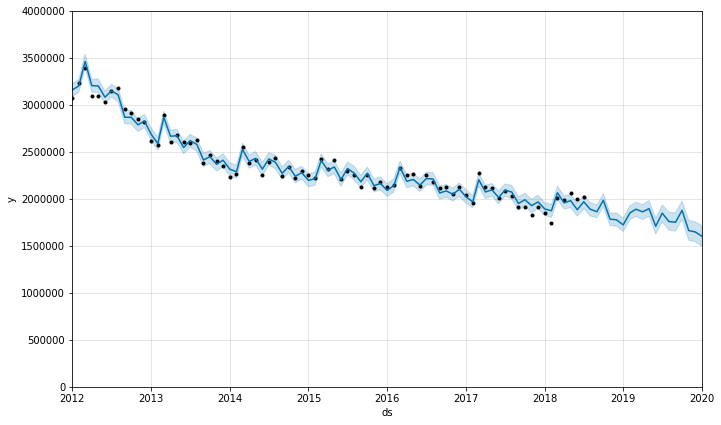

In [22]:
fig_gross = gross.plot(gross_forecast)
gross_ax = plt.gca()
gross_ax.set_xlim(pd.Timestamp('2012'), pd.Timestamp('2020'))
gross_ax.set_ylim([0,4000000])

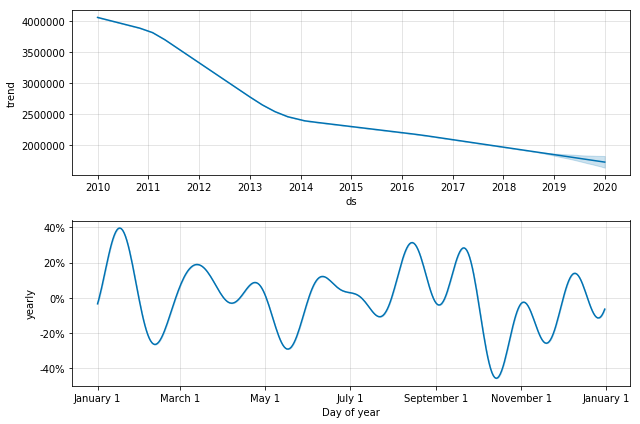

In [23]:
gross_comps=gross.plot_components(gross_forecast)

In [24]:
gross_forecast[gross_forecast['ds'] >= pd.to_datetime('2012-01-01')].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
24,2012-01-01,3.334436e+06,3.088393e+06,3.227619e+06,3.334436e+06,3.334436e+06,-0.052887,-0.052887,-0.052887,-0.052887,-0.052887,-0.052887,0.0,0.0,0.0,3.158086e+06
25,2012-02-01,3.287681e+06,3.134409e+06,3.268279e+06,3.287681e+06,3.287681e+06,-0.025900,-0.025900,-0.025900,-0.025900,-0.025900,-0.025900,0.0,0.0,0.0,3.202529e+06
26,2012-03-01,3.243943e+06,3.394497e+06,3.541635e+06,3.243943e+06,3.243943e+06,0.067316,0.067316,0.067316,0.067316,0.067316,0.067316,0.0,0.0,0.0,3.462313e+06
27,2012-04-01,3.197205e+06,3.133774e+06,3.273101e+06,3.197205e+06,3.197205e+06,0.002258,0.002258,0.002258,0.002258,0.002258,0.002258,0.0,0.0,0.0,3.204424e+06
28,2012-05-01,3.151974e+06,3.133610e+06,3.275917e+06,3.151974e+06,3.151974e+06,0.015752,0.015752,0.015752,0.015752,0.015752,0.015752,0.0,0.0,0.0,3.201625e+06


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


(0, 500000)

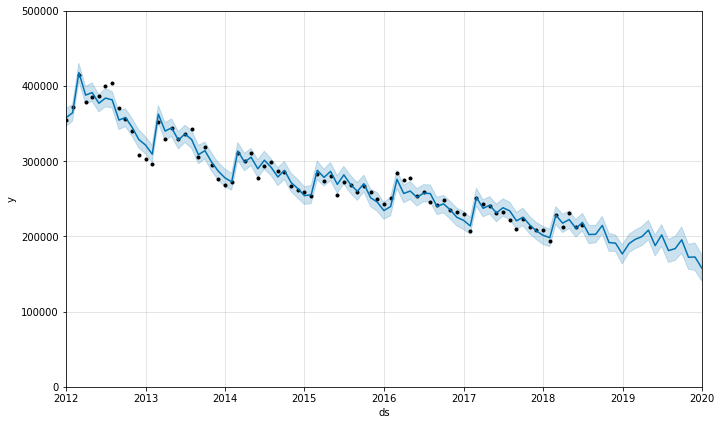

In [25]:
fono, fono_forecast = fitandforecast(df, 'Fonochat')
fig_fono = fono.plot(fono_forecast)
fono_ax = plt.gca()
fono_ax.set_xlim(pd.Timestamp('2012'), pd.Timestamp('2020'))
fono_ax.set_ylim([0,500000])

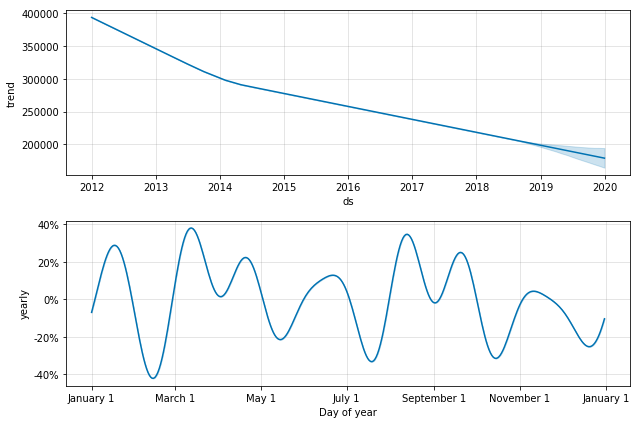

In [26]:
fono_comps = fono.plot_components(fono_forecast[fono_forecast['ds'] >= pd.to_datetime('2012-01-01')])

### Effect of Fourier order on seasonality (totalrev)

In [ ]:
# def seasoncompare(seriess):
#     """Plot the yearly seasonalities of a list of ts objects on a common axis"""
#     fig = plt.figure(figsize=(10,6))
#     ax = fig.add_subplot(111)
#     for i in range(len(seriess)):
#         plot_yearly(seriess[i], ax = plt.gca(), yearly_start=0)
        
#     clr = ['b', 'g', 'r', 'c', 'm', 'k', 'y', 'k', 'k', 'k', 'k', 'k']
#     for i in range(len(seriess)):
#         ax.get_lines()[i].set_color(clr[i])
#         ax.get_lines()[i].set_label(str(i+1))
    
#     plt.legend()
#     ## plt.legend([str[k] for k in range(len(seriess))]) #, bbox_to_anchor=(1.04,1), loc="upper left")


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\JamieG\AppData\Local\conda\conda\envs\ds\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

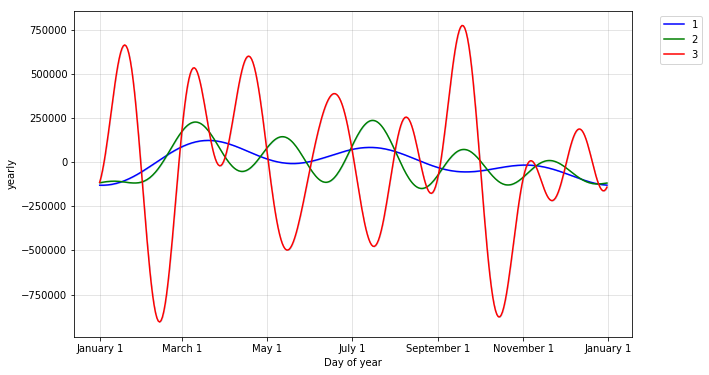

In [21]:
seasoncompare([fitandforecast(df, 'totalrev', fourier=f, mode='additive')[0] for f in range(3,11,3)])

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\JamieG\AppData\Local\conda\conda\envs\ds\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

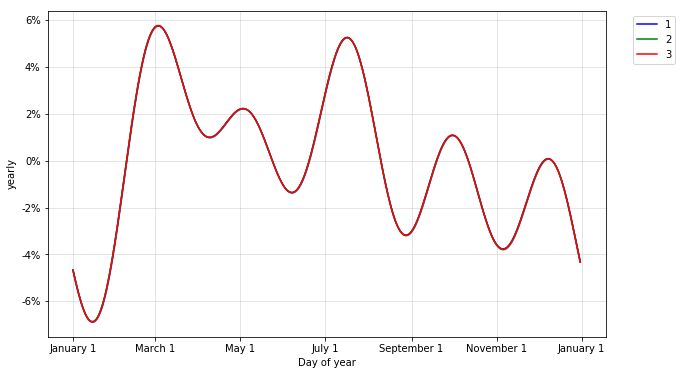

In [23]:
seasoncompare([fitandforecast(df, 'totalrev', fourier=5, mode='multiplicative',
                             season_prior=season_prior)[0] for season_prior in [0.1, 10., 30.]])

### Cross-Validation

In [48]:
df_cv = cross_validation(gross, initial='1080 days', period='365 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2013-07-02 00:00:00 and 2017-07-01 00:00:00
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


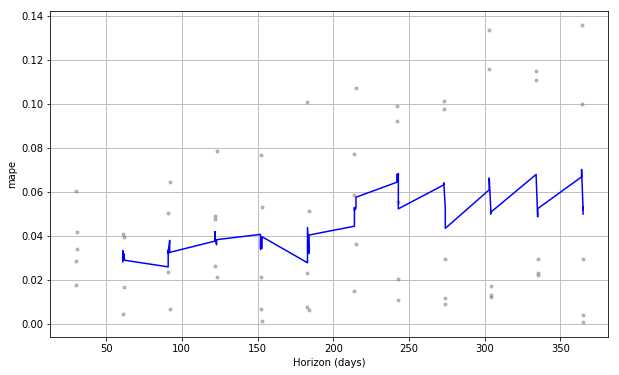

In [49]:
fig_val = plot_cross_validation_metric(df_cv, metric='mape')

INFO:fbprophet.diagnostics:Making 5 forecasts with cutoffs between 2013-07-02 00:00:00 and 2017-07-01 00:00:00
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


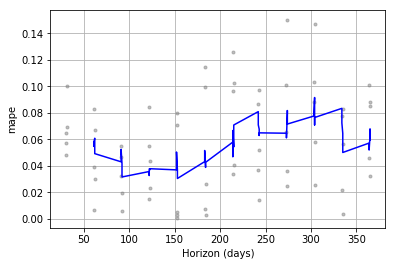

In [50]:
df_cv = cross_validation(fono, initial='1080 days', period='365 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig_val_fono = plot_cross_validation_metric(df_cv, metric='mape', ax=plt.gca())

### Misc. junk

In [54]:
pd.DataFrame(np.random.rand(4,5), columns = list('abcde')).values

array([[0.43154279, 0.04942561, 0.54760677, 0.53123242, 0.2166942 ],
       [0.93579942, 0.15823246, 0.19608278, 0.11724066, 0.12248851],
       [0.55272551, 0.37122336, 0.37051937, 0.53138302, 0.6686059 ],
       [0.5031135 , 0.21931893, 0.7402341 , 0.79247153, 0.55140579]])